# DAP 4

# Imports

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

from sklearn import metrics

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# Process data and create new feature 
df = pd.read_csv("../DAP2/processeddata/aapl.us.csv")
nextDay = df['Open']
df['NextDayOpen'] = nextDay.shift(-1)

# Drop Last Row
df.drop(df.tail(1).index,inplace=True)     
X = df[['Open','High','Low','Close','Volume']]
y = df['NextDayOpen']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Init K-Fold
kf = KFold(n_splits=10, random_state=None, shuffle=True) 

In [3]:
# Parameter finding graph util 
def plot_params(alpha_range, average_r2_train_scores, average_r2_val_scores, average_rmse_scores): 
    plt.figure()
    plt.xlabel('alpha')
    plt.ylabel('R2')
    # plot max R2 scores  
    plt.scatter(alpha_range, average_r2_train_scores, c='r', label='training')
    plt.scatter(alpha_range, average_r2_val_scores, c='b', label='validation')
    plt.legend(loc="upper right")
    max_R2_train_y = max(average_r2_train_scores)
    max_R2_val_y = max(average_r2_val_scores)
    max_R2_train_x = alpha_range[ average_r2_train_scores.index(max_R2_train_y) ] 
    max_R2_val_x = alpha_range[ average_r2_val_scores.index(max_R2_val_y) ] 
    plt.axvline(x=max_R2_train_x, color='r', linestyle=':')
    plt.axhline(y=max_R2_train_y, color='r', linestyle=':')
    plt.axvline(x=max_R2_val_x, color='b', linestyle=':')
    plt.axhline(y=max_R2_val_y, color='b', linestyle=':')
    print('Highest Validation R2:',max_R2_val_y,'at alpha =',max_R2_val_x)
    print('Highest Training R2:',max_R2_train_y,'at alpha =',max_R2_train_x)

    # plot best RMSE 
    plt.figure()
    plt.xlabel('alpha')
    plt.ylabel('RSME')
    plt.scatter(alpha_range, average_rmse_scores, c='g', label="RMSE")
    plt.legend(loc="lower right")
    min_RMSE_y = min(average_rmse_scores)
    min_RMSE_x = alpha_range[ average_rmse_scores.index(min_RMSE_y) ] 
    plt.axvline(x=min_RMSE_x, color='g', linestyle=':')
    plt.axhline(y=min_RMSE_y, color='g', linestyle=':')
    print('Lowest RMSE:',min_RMSE_y,'at alpha =',min_RMSE_x)
    
    # return max_R2_train_x, max_R2_val_x

## Hyper-Parameter Finding

### Ridge Regression Model with Feature Normalization

Highest Validation R2: 0.9995660192703124 at alpha = 0.1
Highest Training R2: 0.9995729149017676 at alpha = 0.1
Lowest RMSE: 0.8514111878193077 at alpha = 0.1


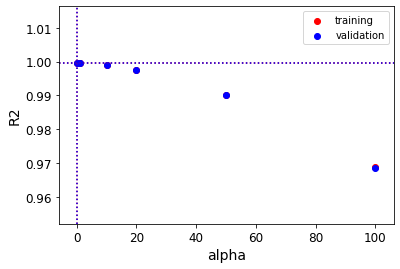

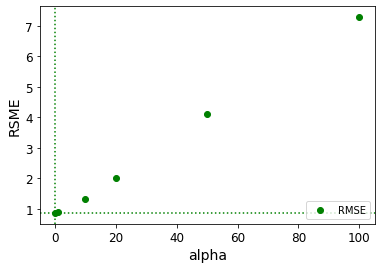

In [4]:
average_r2_train_scores = []
average_r2_val_scores = []
average_rmse_scores = []

alpha_range = [0.1, 1, 10, 20, 50, 100]
for alpha in alpha_range:
    # Preform K-Fold cross validation
    # Get average of R2 train and test, and RMSE
    r2_train_scores = []
    r2_val_scores = []
    rmse_scores = []
    
    for train_index, val_index in kf.split(X_train_scaled):    
        cv_X_train = X_train_scaled[train_index]
        cv_X_val   = X_train_scaled[val_index]
        cv_y_train = y_train[train_index]
        cv_y_val   = y_train[val_index]
        
        linridge = Ridge(alpha = alpha).fit(cv_X_train, cv_y_train)
        r2_train = linridge.score(cv_X_train, cv_y_train)
        r2_val = linridge.score(cv_X_val, cv_y_val)
         
        r2_train_scores.append(r2_train)
        r2_val_scores.append(r2_val)
        
        y_pred = linridge.predict(cv_X_val)
        rmse_scores.append(np.sqrt(metrics.mean_squared_error(cv_y_val, y_pred)))
    
    average_r2_train_scores.append(np.mean(r2_train_scores))
    average_r2_val_scores.append(np.mean(r2_val_scores)) 
    average_rmse_scores.append(np.mean(rmse_scores))
    
plot_params(alpha_range, average_r2_train_scores, average_r2_val_scores, average_rmse_scores)

### Lasso Regression Model with Feature Normalization

Highest Validation R2: 0.9970786436113892 at alpha = 0.5
Highest Training R2: 0.9971038918427555 at alpha = 0.5
Lowest RMSE: 2.2244970239426576 at alpha = 0.5


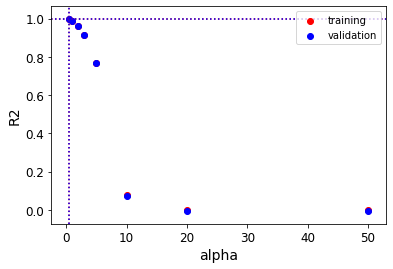

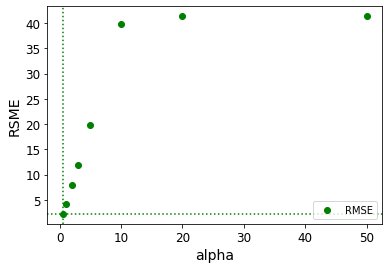

In [5]:
average_r2_train_scores = []
average_r2_val_scores = []
average_rmse_scores = []

alpha_range = [0.5, 1, 2, 3, 5, 10, 20, 50]
for alpha in alpha_range:
    # Preform K-Fold cross validation
    # Get average of R2 train and test, and RMSE
    
    r2_train_scores = []
    r2_val_scores = []
    rmse_scores = []
    
    for train_index, val_index in kf.split(X_train_scaled):    
        cv_X_train = X_train_scaled[train_index]
        cv_X_val   = X_train_scaled[val_index]
        cv_y_train = y_train[train_index]
        cv_y_val   = y_train[val_index]
        
        linlasso = Lasso(alpha, max_iter = 10000).fit(cv_X_train, cv_y_train)
        r2_train = linlasso.score(cv_X_train, cv_y_train)
        r2_val = linlasso.score(cv_X_val, cv_y_val)
         
        r2_train_scores.append(r2_train)
        r2_val_scores.append(r2_val)
        
        y_pred = linlasso.predict(cv_X_val)
        rmse_scores.append(np.sqrt(metrics.mean_squared_error(cv_y_val, y_pred)))
    
    average_r2_train_scores.append(np.mean(r2_train_scores))
    average_r2_val_scores.append(np.mean(r2_val_scores)) 
    average_rmse_scores.append(np.mean(rmse_scores))
    
plot_params(alpha_range, average_r2_train_scores, average_r2_val_scores, average_rmse_scores)

### Polynomial Regression Model

Highest Validation R2: 0.9996611571759317 at alpha = 2
Highest Training R2: 0.999716247200014 at alpha = 4
Lowest RMSE: 0.7423545753734704 at alpha = 2


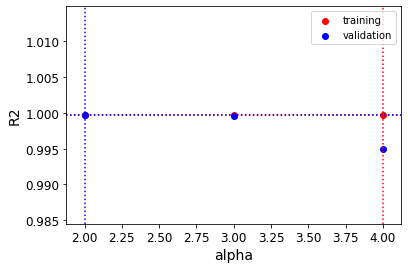

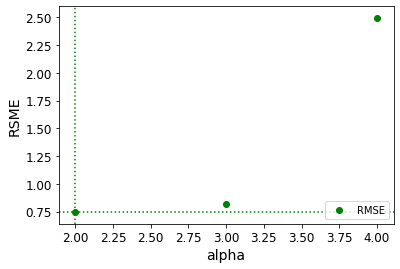

In [7]:
average_r2_train_scores = []
average_r2_val_scores = []
average_rmse_scores = []

degree_range = range(2, 5)
for degree in degree_range:
    
    r2_train_scores = []
    r2_val_scores = []
    rmse_scores = []
    
    for train_index, val_index in kf.split(X_train_scaled): # Scaled?
        cv_X_train = X_train_scaled[train_index]
        cv_X_val   = X_train_scaled[val_index]
        cv_y_train = y_train[train_index]
        cv_y_val   = y_train[val_index]
        
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        cv_X_train_poly = poly_features.fit_transform(cv_X_train)
        cv_X_val_poly = poly_features.fit_transform(cv_X_val)
        
        polyreg = LinearRegression().fit(cv_X_train_poly, cv_y_train)
        
        r2_train = polyreg.score(cv_X_train_poly, cv_y_train)
        r2_val = polyreg.score(cv_X_val_poly, cv_y_val)
         
        r2_train_scores.append(r2_train)
        r2_val_scores.append(r2_val)
        
        y_pred = polyreg.predict(cv_X_val_poly)
        rmse_scores.append(np.sqrt(metrics.mean_squared_error(cv_y_val, y_pred)))
    
    average_r2_train_scores.append(np.mean(r2_train_scores))
    average_r2_val_scores.append(np.mean(r2_val_scores)) 
    average_rmse_scores.append(np.mean(rmse_scores))
    
plot_params(degree_range, average_r2_train_scores, average_r2_val_scores, average_rmse_scores)

## Model Evaluation

In [8]:
# New split to evaluate data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Re-fit and scale 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Learning curve util 
def plot_learning_curve(model, X_train_scaled, X_test_scaled, y_train, y_test):
    train_errors, test_errors = [], []
    plt.figure()
    for m in range(1, len(X_train_scaled)):
        model.fit(X_train_scaled[:m], y_train[:m])
        y_train_predict = model.predict(X_train_scaled[:m])
        y_test_predict = model.predict(X_test_scaled)
        train_errors.append(np.sqrt(mean_squared_error(y_train[:m], y_train_predict)))
        test_errors.append(np.sqrt(mean_squared_error(y_test, y_test_predict)))
    # Plot the curve
    plt.title('MultiVar Linear Reg')
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="lower right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)   

### Multivariate Linear Regression Model

Training R2 Score: 0.9996690703654064
Test R2 Score: 0.999611269458309
RMSE: 0.8298328718799092


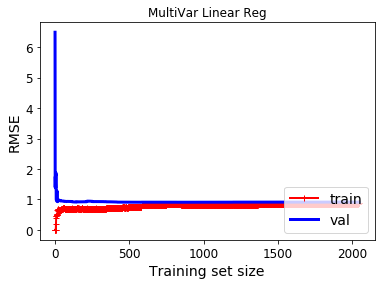

In [9]:
linreg = LinearRegression().fit(X_train_scaled, y_train)

r2_train_score = linreg.score(X_train_scaled, y_train)
r2_test_score = linreg.score(X_test_scaled, y_test)

y_pred = linreg.predict(X_test_scaled)
rmse_score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Training R2 Score:',r2_train_score)
print('Test R2 Score:',r2_test_score)
print('RMSE:',rmse_score)

plot_learning_curve(linreg, X_train_scaled, X_test_scaled, y_train, y_test)

### Multivariate Linear Regression Model with Gradient Descent

In [13]:
learning_rate = 0.05
n_iterations = 10
n = len(X_train_scaled)
theta = np.random.randn(6,1) 
        
X_b = np.c_[np.ones((len(X_train), 1)), X_train] # Training
X_new_b = np.c_[np.ones((len(X_test), 1)), X_test] # Test
       
for iteration in range(n_iterations): # Train Model
    gradients = 2/n * X_b.T.dot(X_b.dot(theta) - y_train)
    theta = theta - learning_rate * gradients

y_pred = X_new_b.dot(theta) # Prediction of theta for each feature

#y_test_b = y_test
#y_test_b.reshape(409, 1)

#rmse_score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
#print(rmse_score)

### Ridge Regression Model with Feature Normalization

Training R2 Score: 0.9995771862238924
Test R2 Score: 0.9994813210933264
RMSE: 0.9585518197132838


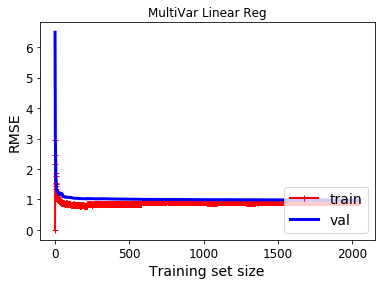

In [14]:
linridge = Ridge(alpha=0.1).fit(X_train_scaled, y_train)

r2_train_score = linridge.score(X_train_scaled, y_train)
r2_test_score = linridge.score(X_test_scaled, y_test)

y_pred = linridge.predict(X_test_scaled)
rmse_score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Training R2 Score:',r2_train_score)
print('Test R2 Score:',r2_test_score)
print('RMSE:',rmse_score)

plot_learning_curve(linridge, X_train_scaled, X_test_scaled, y_train, y_test)

### Lasso Regression Model with Feature Normalization

Training R2 Score: 0.9971047758043025
Test R2 Score: 0.9973063866910095
RMSE: 2.184408849243356


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


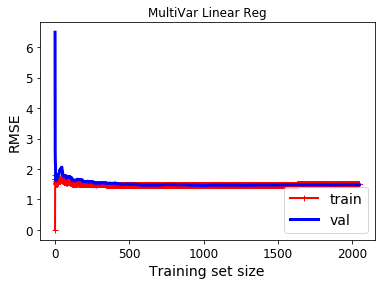

In [15]:
linlasso = Lasso(alpha=0.5, max_iter=10000).fit(X_train_scaled, y_train) # TOL FIX

r2_train_score = linlasso.score(X_train_scaled, y_train)
r2_test_score = linlasso.score(X_test_scaled, y_test)

y_pred = linlasso.predict(X_test_scaled)
rmse_score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Training R2 Score:',r2_train_score)
print('Test R2 Score:',r2_test_score)
print('RMSE:',rmse_score)

plot_learning_curve(linlasso, X_train_scaled, X_test_scaled, y_train, y_test)

### Polynomial Regression Model

Training R2 Score: 0.9840315059937794
Test R2 Score: 0.9835031582183978
RMSE: 5.405883811916705


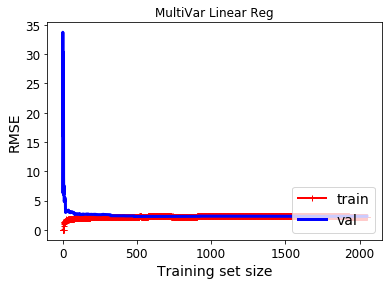

In [16]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)
        
polyreg = LinearRegression().fit(X_train_poly, y_train)

r2_train_score = polyreg.score(X_train_poly, y_train)
r2_test_score = polyreg.score(X_test_poly, y_test)

y_pred = polyreg.predict(X_test_poly)
rmse_score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Training R2 Score:',r2_train_score)
print('Test R2 Score:',r2_test_score)
print('RMSE:',rmse_score)

plot_learning_curve(polyreg, X_train_poly, X_test_poly, y_train, y_test)

## Summary

We found that our models often had extremely high R2 values on testing, training and validation. Furthermore, we found that our models had very low RMSE on average as well. This could be due to overfitting of the data, however our learning curves indicate no obvious overfitted data. Additionally, this could be attributed to our feature engineering, as we have create a column NextOpen from existing values, and thus our predicted values when interpreted may not give any accurate indication of performance. 

In [17]:
"""
TO TALK ABT W/ DR. BAE

1.) Gradient D Implementation
2.) Lasso Tolerance/Max Iterations 
3.) Possible overfitting in our models
"""

'\nTO TALK ABT W/ DR. BAE\n\n1.) Gradient D Implementation\n2.) Lasso Tolerance/Max Iterations \n3.) Possible overfitting in our models\n'